### 1. 环境准备

In [30]:
# 自动重载自定义模块
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath(".."))

from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct, col, when, isnan, count, mean
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

# 创建 SparkSession
print("🔧 Initializing Spark...")
spark = SparkSession.builder \
    .appName("EDA_Resource_Request_Analysis") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .getOrCreate()
print("当前 Spark 版本为:", spark.version)
print("✅ Spark initialized.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
🔧 Initializing Spark...
当前 Spark 版本为: 3.5.5
✅ Spark initialized.


### 2. 加载清洗后的Parquet数据

In [31]:
df_clean = spark.read.parquet("../data/cleaned_borg_data.parquet")
print("\nLoaded cleaned data successfully!")

print("\nSchema:")
df_clean.printSchema()


Loaded cleaned data successfully!

Schema:
root
 |-- _c0: string (nullable = true)
 |-- time: double (nullable = true)
 |-- instance_events_type: string (nullable = true)
 |-- collection_id: long (nullable = true)
 |-- scheduling_class: integer (nullable = true)
 |-- collection_type: string (nullable = true)
 |-- priority: integer (nullable = true)
 |-- alloc_collection_id: string (nullable = true)
 |-- instance_index: double (nullable = true)
 |-- machine_id: double (nullable = true)
 |-- resource_request: string (nullable = true)
 |-- constraint: string (nullable = true)
 |-- collections_events_type: string (nullable = true)
 |-- user: string (nullable = true)
 |-- collection_name: string (nullable = true)
 |-- collection_logical_name: string (nullable = true)
 |-- start_after_collection_ids: string (nullable = true)
 |-- vertical_scaling: integer (nullable = true)
 |-- scheduler: integer (nullable = true)
 |-- start_time: double (nullable = true)
 |-- end_time: double (nullable = t

### 3. 基本统计总览

In [32]:
# 总作业数、任务数、机器数
num_collections = df_clean.select(countDistinct("collection_id")).collect()[0][0]
num_tasks = df_clean.select("collection_id", "instance_index").distinct().count()
num_machines = df_clean.select(countDistinct("machine_id")).collect()[0][0]

# 时间范围
min_time = df_clean.agg({"time": "min"}).collect()[0][0]
max_time = df_clean.agg({"end_time": "max"}).collect()[0][0]
time_range_hours = (max_time - min_time) / 1e6 / 60 / 60

print(f"\n总集合数: {num_collections}")
print(f"总任务数: {num_tasks}")
print(f"总机器数: {num_machines}")
print(f"时间跨度约: {time_range_hours:.2f} 小时")


总集合数: 4063
总任务数: 242963
总机器数: 96176
时间跨度约: 744.08 小时


### 4. 资源请求量分布（直方图，自动裁剪极端值）

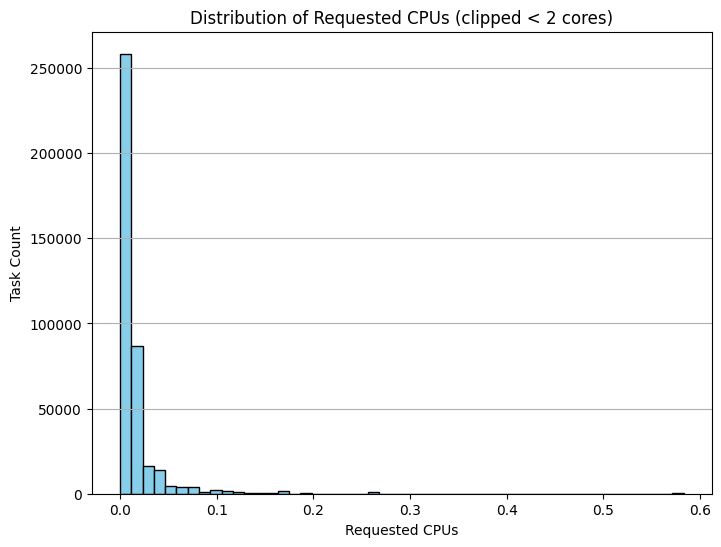

In [33]:
# 裁剪：仅保留 requested_cpus < 2 的记录
cpu_req_pd = df_clean.filter((col("requested_cpus") > 0) & (col("requested_cpus") < 2))\
    .select("requested_cpus").dropna().toPandas()

plt.figure(figsize=(8,6))
plt.hist(cpu_req_pd["requested_cpus"], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Requested CPUs")
plt.ylabel("Task Count")
plt.title("Distribution of Requested CPUs (clipped < 2 cores)")
plt.grid(axis='y')
plt.show()

### 5. 资源利用率分布（裁剪后绘图）

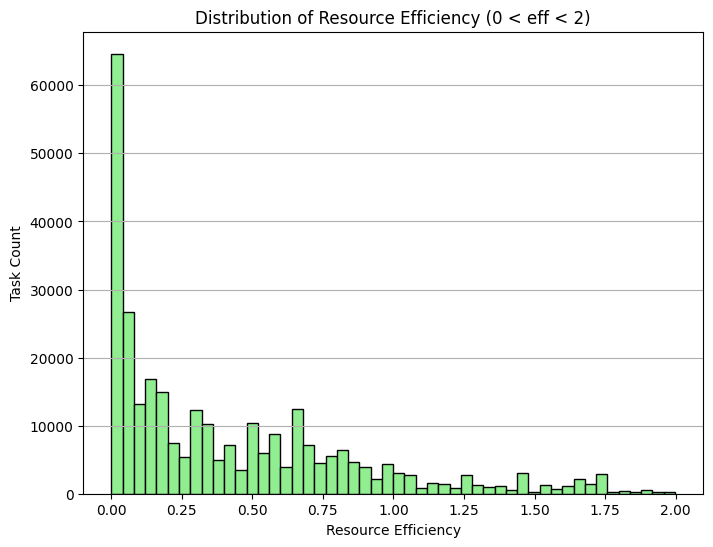

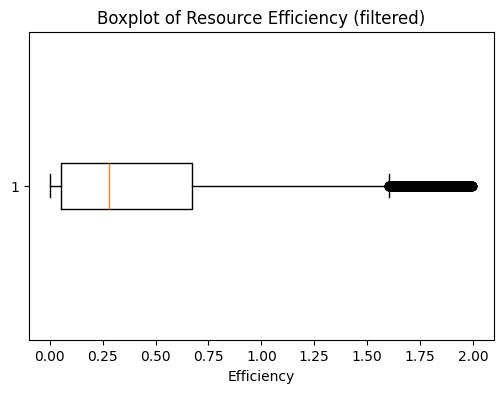

In [34]:
# 裁剪效率：保留 0 < efficiency < 2 范围
eff_pd = df_clean.filter((col("resource_efficiency") > 0) & (col("resource_efficiency") < 2))\
    .select("resource_efficiency").dropna().toPandas()

# 直方图
plt.figure(figsize=(8,6))
plt.hist(eff_pd["resource_efficiency"], bins=50, color='lightgreen', edgecolor='black')
plt.xlabel("Resource Efficiency")
plt.ylabel("Task Count")
plt.title("Distribution of Resource Efficiency (0 < eff < 2)")
plt.grid(axis='y')
plt.show()

# 箱线图
plt.figure(figsize=(6,4))
plt.boxplot(eff_pd["resource_efficiency"], vert=False)
plt.title("Boxplot of Resource Efficiency (filtered)")
plt.xlabel("Efficiency")
plt.show()

### 6. 排队延迟分析（queueing_delay）

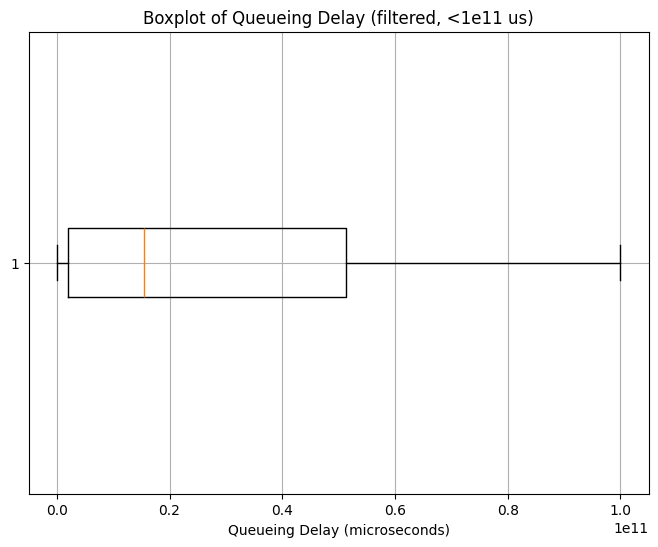

In [35]:
# 过滤极端值和缺失值：0 < delay < 1e11 (~1h)
delay_pd = df_clean.filter((col("queueing_delay") > 0) & (col("queueing_delay") < 1e11))\
    .select("queueing_delay").dropna().toPandas()

plt.figure(figsize=(8,6))
plt.boxplot(delay_pd["queueing_delay"], vert=False)
plt.title("Boxplot of Queueing Delay (filtered, <1e11 us)")
plt.xlabel("Queueing Delay (microseconds)")
plt.grid(True)
plt.show()

In [36]:
### 7. 成功率 vs 失败率分析

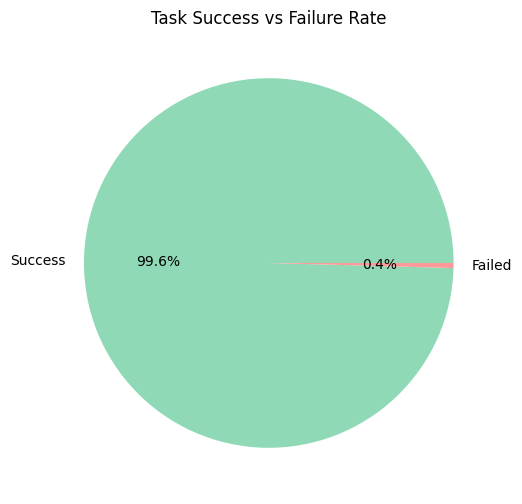

In [37]:
# 统计成功/失败任务数
fail_counts = df_clean.groupBy("failed").count().toPandas()
labels = ["Success", "Failed"]
counts = [fail_counts.loc[fail_counts["failed"] == 0, "count"].values[0],
           fail_counts.loc[fail_counts["failed"] == 1, "count"].values[0]]

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=["#8fd9b6", "#ff9999"])
plt.title("Task Success vs Failure Rate")
plt.show()

### 8. 不同调度器的效率与延迟分析（箱线图）

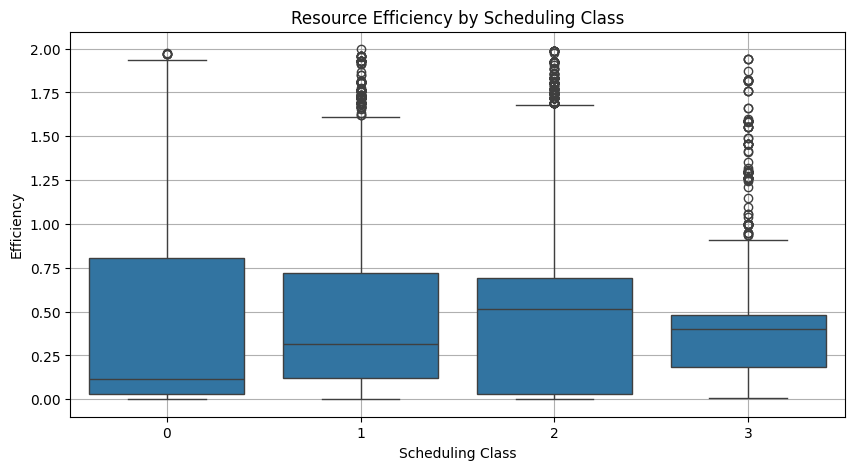

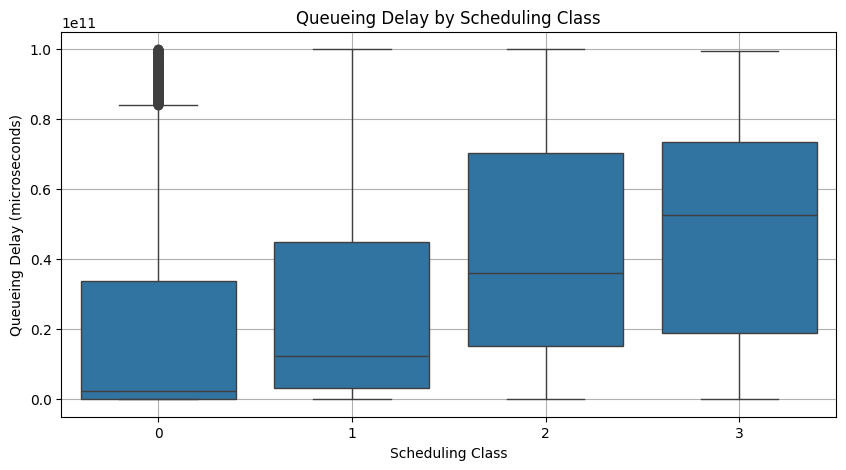

In [38]:
# 过滤效率和延迟的极端值，保留合理区间后再做分组
scheduler_pd = df_clean.filter((col("resource_efficiency") > 0) & (col("resource_efficiency") < 2) & 
                                (col("queueing_delay") > 0) & (col("queueing_delay") < 1e11))\
    .select("scheduling_class", "resource_efficiency", "queueing_delay")\
    .dropna().toPandas()

plt.figure(figsize=(10,5))
sns.boxplot(x="scheduling_class", y="resource_efficiency", data=scheduler_pd)
plt.title("Resource Efficiency by Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Efficiency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="scheduling_class", y="queueing_delay", data=scheduler_pd)
plt.title("Queueing Delay by Scheduling Class")
plt.xlabel("Scheduling Class")
plt.ylabel("Queueing Delay (microseconds)")
plt.grid(True)
plt.show()

### 9.任务失败率是否与资源请求大小（CPU、内存）

数据样例：
+--------------------+--------------------+------+
|         cpu_request|         mem_request|failed|
+--------------------+--------------------+------+
|   0.018402099609375|0.001302719116210...|     0|
|   0.007293701171875| 0.00725555419921875|     0|
| 0.00704193115234375|0.001302719116210...|     0|
|0.001241683959960...|    2.13623046875E-4|     0|
|8.802413940429688E-4|  0.0010528564453125|     0|
+--------------------+--------------------+------+
only showing top 5 rows

有效记录总数：398771


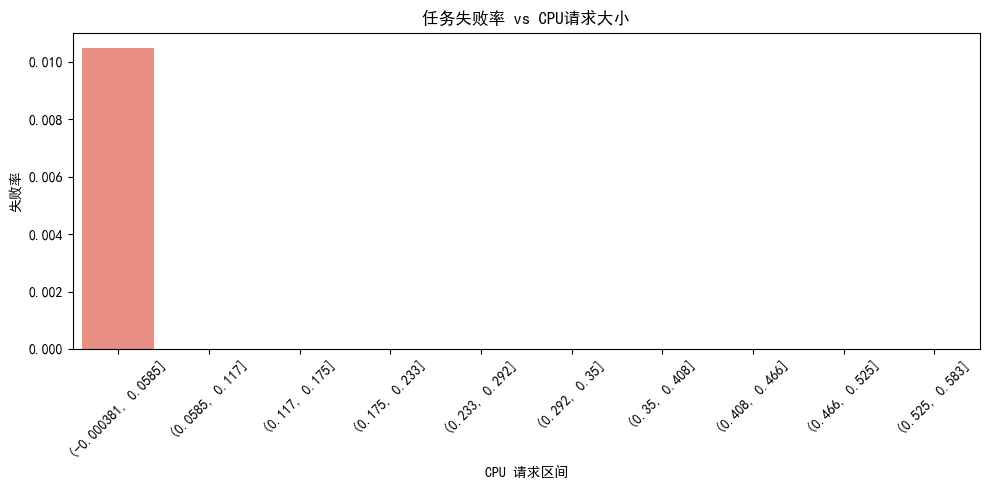

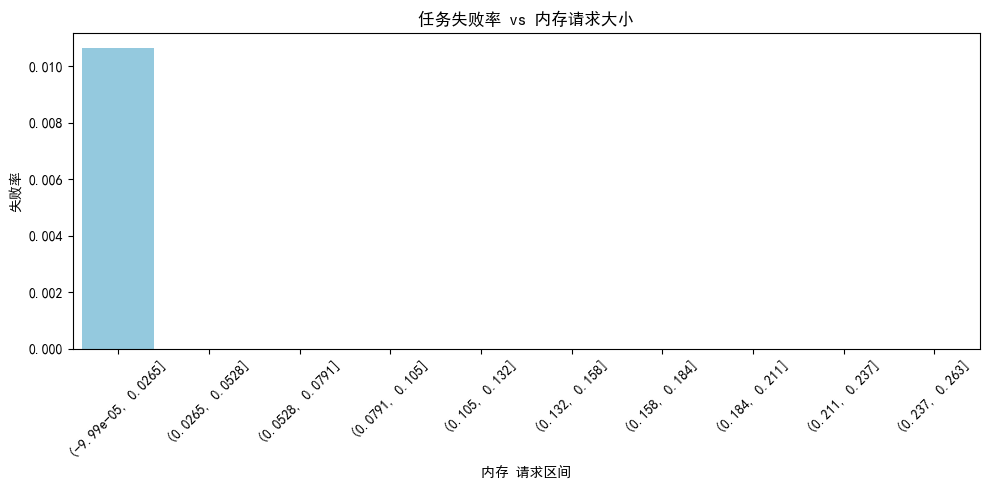

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract

# 初始化 Spark（优化配置）
spark = SparkSession.builder \
    .appName("EDA_Failure_Rate_vs_Resource") \
    .config("spark.executor.python.worker.timeout", "300") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "5000") \
    .getOrCreate()

# 读取数据
df_clean = spark.read.parquet("../data/cleaned_borg_data.parquet")

# 高效解析字段
df_parsed = df_clean.filter(
    col("resource_request").isNotNull() & col("failed").isNotNull()
).withColumn(
    "cpu_request", 
    regexp_extract(col("resource_request"), r"'cpus':\s*([\d.]+)", 1).cast("double")
).withColumn(
    "mem_request",
    regexp_extract(col("resource_request"), r"'memory':\s*([\d.]+)", 1).cast("double")
).filter(
    (col("cpu_request") > 0) & (col("mem_request") > 0)
)

# 验证数据质量
print("数据样例：")
df_parsed.select("cpu_request", "mem_request", "failed").show(5)
print(f"有效记录总数：{df_parsed.count()}")

# 高效采样转换
df_all = df_parsed.select("cpu_request", "mem_request", "failed") \
    .sample(withReplacement=False, fraction=0.1) \
    .limit(4000) \
    .toPandas()

# 可视化分析（保持原有代码不变）
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ...（保持原有的绘图代码不变）
# 任务失败率 vs CPU 请求大小
df_all["cpu_bin"] = pd.cut(df_all["cpu_request"], bins=10)
cpu_grouped = df_all.groupby("cpu_bin", observed=False)["failed"].agg(["count", "sum"])
cpu_grouped["failure_rate"] = cpu_grouped["sum"] / cpu_grouped["count"]

plt.figure(figsize=(10, 5))
sns.barplot(x=cpu_grouped.index.astype(str), y=cpu_grouped["failure_rate"], color="salmon")
plt.title("任务失败率 vs CPU请求大小")
plt.ylabel("失败率")
plt.xlabel("CPU 请求区间")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 任务失败率 vs MEM 请求大小
df_all["mem_bin"] = pd.cut(df_all["mem_request"], bins=10)
mem_grouped = df_all.groupby("mem_bin", observed=False)["failed"].agg(["count", "sum"])
mem_grouped["failure_rate"] = mem_grouped["sum"] / mem_grouped["count"]

plt.figure(figsize=(10, 5))
sns.barplot(x=mem_grouped.index.astype(str), y=mem_grouped["failure_rate"], color="skyblue")
plt.title("任务失败率 vs 内存请求大小")
plt.ylabel("失败率")
plt.xlabel("内存 请求区间")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 最后确保关闭Spark
spark.stop()